# Poisson's equation

Now extend your solver to solve for Poisson's equation.
* Consider a 64 x 64 grids in a domain ($-1<x<1$ and $-1<y<1$)
* Assume $\rho(r)= \exp(-10r)$
* Assume $u$ is zero on the four boundaries.
* Solver for the potential $u$.
* What is the corresponding electrical (or gravitational) field? (Hints: use `numpy.gradient()`)

In [1]:
import numpy as np
from scipy.sparse import diags_array  # if dia_array is not able, use dia_matrix
from scipy.sparse import eye_array
from scipy.sparse import csc_matrix
import scipy.sparse.linalg as splinalg
from numba import jit, njit, prange,set_num_threads
import matplotlib.pyplot as plt

In [2]:
# Copy your Laplace's Equation solver from demo1 here
def generate_the_laplace_matrix_with_size(N=4):
    """
    assume sqrt(N) is an integer.

    """
    A = np.zeros([N**2,N**2])
    a44  = diags_array([-1,4,-1],offsets=[-1,0,1],shape=(N,N)).toarray()
    neye = -eye_array(N).toarray()
    for i in range(N):
        for j in range(N):
            if i==j:
                submatrix=a44
            elif (abs(i-j)==1):
                submatrix=neye
            else:
                submatrix=np.zeros((N,N))
            
            for ii in range(N):
                for jj in range(N):
                    A[i*N+ii,j*N+jj]=submatrix[ii,jj]
    return A


The right hand side vector need to be updated when there is a density field $\rho$.
First, we write a function `generate_rho()` to generate the $N \times N$ density field.

In [3]:
def generate_rho(N=64, xmin=-1, xmax=1, ymin=-1,ymax=1):
    # TODO:
    x = np.linspace(xmin,xmax,N)
    y = np.linspace(ymin,ymax,N)
    X,Y = np.meshgrid(x,y)
    R = np.sqrt(X**2+Y**2)
    rho = np.exp(-10*R)
    return rho

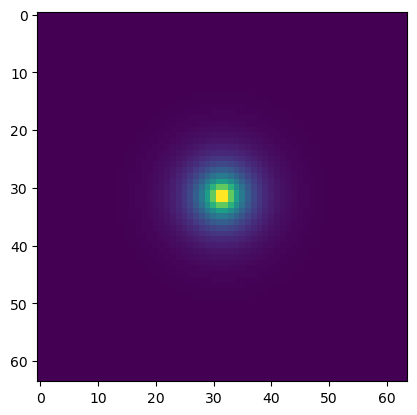

In [4]:
# Visualize the density field
rho = generate_rho(N=64)
plt.imshow(rho)

Once we have the density filed, we need to modify the `generate_the_rhs_vector_with_size()` to include the density field.

In [18]:
def generate_the_rhs_vector_with_size(N=4, rho=None, dx=1):
    if rho is None:
        b = np.zeros(N*N)
        b[N*(N-1):N*N] = 1
    else:
        b = rho.flatten()
        b = -dx**2*b
        b[-N:] += 0

    return b

We could solve the system by the same way in `solve_laplace()`.

In [26]:
def convert_solution(x):
    usize = np.sqrt(len(x))
    u = x.reshape(int(usize),int(usize)).transpose()
    return u

def solve_laplace(N=16):
    A = generate_the_laplace_matrix_with_size(N=N)

    rho = generate_rho(N=N)
    b = generate_the_rhs_vector_with_size(N=N, rho=rho, dx=2/(N-1))
    #x = linalg.solve(A,b) # use scipy
    #x = lu_solve(A,b)      # use our solver
    x = splinalg.spsolve(A,b) # use scipy sparse solver
    u = convert_solution(x)
    return u

In [27]:
u = solve_laplace(N=64)

/var/folders/p2/n9vkqcb17jl0gjj6vxxr29m80000gn/T/ipykernel_2042/3849091919.py:13: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  x = splinalg.spsolve(A,b) # use scipy sparse solver


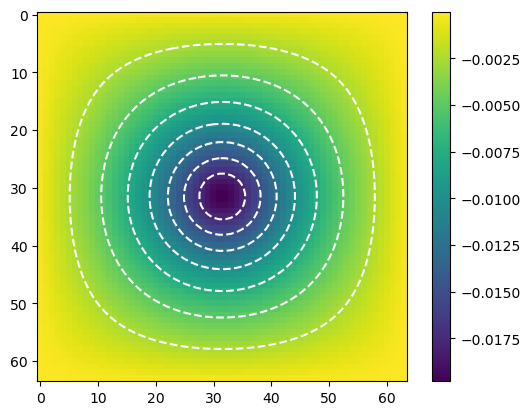

In [28]:
# Visualize the solution
plt.imshow(u.T)
plt.colorbar()
plt.contour(u.T,colors="w")

Calculate the gravitational field

In [31]:
phi =np.gradient(u)

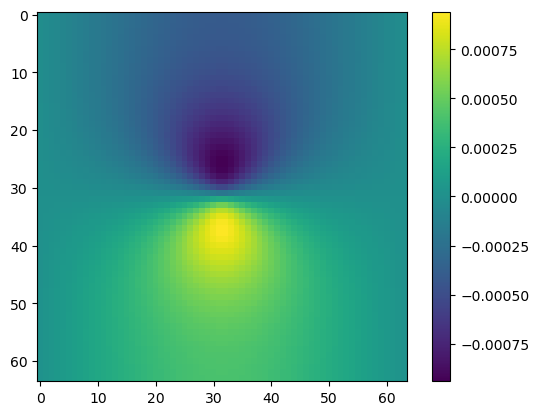

In [34]:
plt.imshow(phi[0]) # x derivative
plt.colorbar()

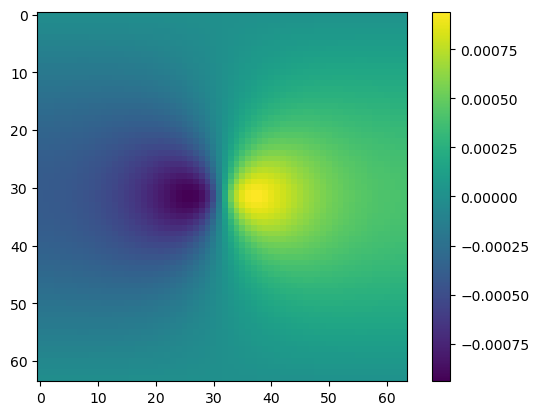

In [36]:
plt.imshow(phi[1]) # y derivative
plt.colorbar()